# Exploitation Comparison of Different Zero-sum Game Methods
The figures show the learning curve of the exploiter after the model is trained with different type of methods. The exploiter is set as the second player for all envs and methods.

In [1]:
import json
import os, re
import numpy as np

def load_data(file_name):
    file_dir = folder+file_name
    # print(file_dir)
    
    data = json.load( open(file_dir+"/eval.json"))
    # print(data.keys())
    return data

def smooth(y, radius=200, mode='two_sided'):
    if len(y) < 2*radius+1:
        return np.ones_like(y) * y.mean()
    elif mode == 'two_sided':
        convkernel = np.ones(2 * radius+1)
        return np.convolve(y, convkernel, mode='same') / \
                np.convolve(np.ones_like(y), convkernel, mode='same')
    elif mode == 'causal':
        convkernel = np.ones(radius)
        out = np.convolve(y, convkernel,mode='full') / \
                np.convolve(np.ones_like(y), convkernel, mode='full')
        return out[:-radius+1]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['savefig.facecolor']='white'
# plt.style.use('seaborn-whitegrid')
plt.style.use('default')
import matplotlib.cm as cm


def plot(x, data, method, color, agent_to_plot, smooth_radius=200, range=100000):
    def smooth(y, radius=200, mode='two_sided'):
        if len(y) < 2*radius+1:
            return np.ones_like(y) * y.mean()
        elif mode == 'two_sided':
            convkernel = np.ones(2 * radius+1)
            return np.convolve(y, convkernel, mode='same') / \
                   np.convolve(np.ones_like(y), convkernel, mode='same')
        elif mode == 'causal':
            convkernel = np.ones(radius)
            out = np.convolve(y, convkernel,mode='full') / \
                  np.convolve(np.ones_like(y), convkernel, mode='full')
            return out[:-radius+1]

    k = method
    v = data[agent_to_plot]
    try:
        plt.plot(x, v[:range], color=color, alpha=0.2)
        plt.plot(x, smooth(v[:range], radius=smooth_radius), color=color, label=k)
    except:
        pass


In [22]:
import os
import sys
import pandas as pd  
pd.set_option('display.max_rows', None)  # or 1000

envs = ['double_dunk', 'boxing', 'surround', 'pong', 'tennis', 'slimevolley']
indices = ['20220421_1855', '20220429_0152', '20220427_1507']

exploited_models = ['first', 'second']
times=  ['1', '2', '3']
results = [[[[[10 for _ in exploited_models] for _ in times] for _ in indices] for _ in range(7)] for _ in envs]
all_rewards = [[[[[[0] for _ in exploited_models] for _ in times] for _ in indices] for _ in range(7)] for _ in envs]
methods = ['fictitious_selfplay2', 'nash_dqn', 'nash_dqn_exploiter', 'nash_ppo', 'nfsp', 'nxdo2', 'selfplay2']

print(np.array(results).shape)
for m, index in enumerate(indices):
    for i, exploited_model in enumerate(exploited_models):
        for t in times:
            os.makedirs(f'{index}_exploit/{exploited_model}_{t}', exist_ok=True)
            folder = f'../data/log/{index}_exploit_{exploited_model}_{t}/'
            files = ! ls $folder
            # print(files)
            if exploited_model == 'first':
                agent_to_plot = 'second_0'  # 'first_0' or 'second_0'
            else:
                agent_to_plot = 'first_0'

            for j, env in enumerate(envs):
                env_files =[f for f in files if env in f]
                # print(env_files)
                # methods = []
                for _, f in enumerate(env_files):
                    data = load_data(f)
                    method = re.split('v(\d+)_', f)[-1] # split with 'v*'
                    # methods.append(method)
                    v = smooth(data['episode_reward'][agent_to_plot], radius=50)
                    max_exploiter_reward = max(v)  # max exploiter reward in smoothed evaluation curve
                    # print(env, method, agent_to_plot, max_exploiter_reward)
                    k = methods.index(method)  # some log can miss, use this give correct index
                    results[j][k][m][int(t)-1][i] = max_exploiter_reward  # env, method, indx, time, exploit_idx 
                    all_rewards[j][k][m][int(t)-1][i] = data['episode_reward']
                    episode = data['episode']

results = np.array(results)
print(results.shape)
idx1 = np.argmin(results, axis=-1)  # exploit_idx
results = np.min(results, axis=-1) # less exploitable one
print(results.shape)
idx2 = np.argmax(results, axis=-1)  # time
results = np.max(results, axis=-1) # most exploitable exploiter
print(results.shape)
idx3 = np.argmin(results, axis=-1)  # indx
results = np.min(results, axis=-1) # less exploitable model
print(results.shape, results)
print(idx1.shape, idx2.shape, idx3.shape)


results_dict = {}
for k, method in enumerate(methods):
    results_dict[method] = results[:, k]
df = pd.DataFrame(results_dict, index=envs)
print(df)

(6, 7, 3, 3, 2)
(6, 7, 3, 3, 2)
(6, 7, 3, 3)
(6, 7, 3)
(6, 7) [[ 6.06779661e+00 -5.39473684e-01  1.70297030e+00 -2.37623762e-01
   4.56435644e+00  7.25641026e+00  7.03960396e+00]
 [ 9.36831683e+01 -5.54714286e+01  2.24901961e+01  7.96071429e+01
   0.00000000e+00  6.68910891e+01  2.49076923e+01]
 [ 1.57425743e+00  9.04255319e-01  1.32467532e+00  4.65346535e-01
   1.59405941e+00  1.60396040e+00  1.78217822e+00]
 [ 5.19607843e+00 -3.33663366e+00 -2.92079208e+00 -1.38613861e-01
   4.39603960e+00  5.21782178e+00  4.20792079e+00]
 [ 2.35593220e+00 -4.25742574e-01 -1.22058824e+00 -1.49504950e+00
   3.20792079e+00  2.46534653e+00  2.97029703e+00]
 [ 5.14851485e-01  0.00000000e+00 -9.90099010e-02 -8.80952381e-01
   6.93069307e-02  0.00000000e+00 -4.95049505e-02]]
(6, 7, 3, 3) (6, 7, 3) (6, 7)
             fictitious_selfplay2   nash_dqn  nash_dqn_exploiter   nash_ppo  \
double_dunk              6.067797  -0.539474            1.702970  -0.237624   
boxing                  93.683168 -55.471429   

1


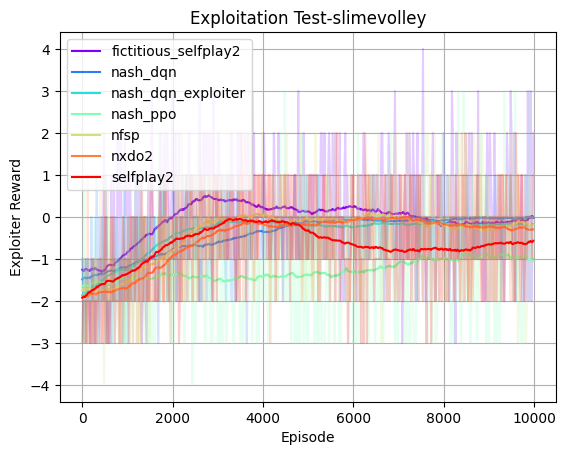

In [23]:
colors = cm.rainbow(np.linspace(0, 1, 7))
os.makedirs(f'selected_exploit', exist_ok=True)

for env, idx1_env, idx2_env, idx3_env, rewards_env in zip(envs, idx1, idx2, idx3, all_rewards):
    plt.clf()
    for method, idx1_env_m, idx2_env_m, idx3_env_m, rewards_env_m, c in zip(methods, idx1_env, idx2_env, idx3_env, rewards_env, colors):

        index = indices[idx3_env_m]
        t = idx2_env_m[idx3_env_m]
        exploit_idx = idx1_env_m[idx3_env_m][t]
        time = t + 1

        if exploit_idx == 0:
            exploited_model = 'first'
        else:
            exploited_model = 'second'

        folder = f'../data/log/{index}_exploit_{exploited_model}_{time}/'
        # print(folder)
        files = ! ls $folder       
        
        if exploited_model == 'first':
            agent_to_plot = 'second_0'  # 'first_0' or 'second_0'
        else:
            agent_to_plot = 'first_0'
        # print(np.array(rewards_env_m).shape, idx3_env_m, t, exploit_idx)
        episode_reward = rewards_env_m[idx3_env_m][t][exploit_idx]
        
        for f in files:
            if env in f and method in f:
                plot(episode, episode_reward, method, c, agent_to_plot, smooth_radius=50)
                break

    plt.legend()
    plt.grid()
    plt.title(f'Exploitation Test-{env}')
    plt.xlabel('Episode')
    plt.ylabel('Exploiter Reward')
    savepath=f'selected_exploit/compare_exploitation_{env}.png'
    plt.savefig(savepath, bbox_inches='tight',)

